<h2>Problem Statement</h2> To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
#Setting random seed for tensorflow
tf.random.set_seed(123)


### Mounting Google Drive And Defining the Path containing the images (Train and Test)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Deep Learning Projects/CS-Melanoma/original data/data/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Deep Learning Projects/CS-Melanoma/original data/data/Test')

##### Printing the Samples count in train and test

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


---

## Loading The Data And Visualisation

In [5]:
# defining the batch size and image dimensions

batch_size = 32
img_height = 180
img_width = 180

#### Loading the Train, Validation, Test Data

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory = data_dir_train,
                                                              labels = 'inferred',
                                                              batch_size = batch_size,
                                                              image_size = (img_height, img_width),
                                                              shuffle = True,
                                                              seed = 123,
                                                              validation_split=0.2,
                                                              subset='training')

val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory = data_dir_train,
                                                              labels = 'inferred',
                                                              batch_size = batch_size,
                                                              image_size = (img_height, img_width),
                                                              shuffle = True,
                                                              seed = 123,
                                                              validation_split=0.2,
                                                              subset='validation')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                            image_size=(img_height, img_width),
                                                            batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.


In [7]:
#Printing the Different Class Names present in the data
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


---

### Data Visualization


### 1. Visualising an Instance of Each Class

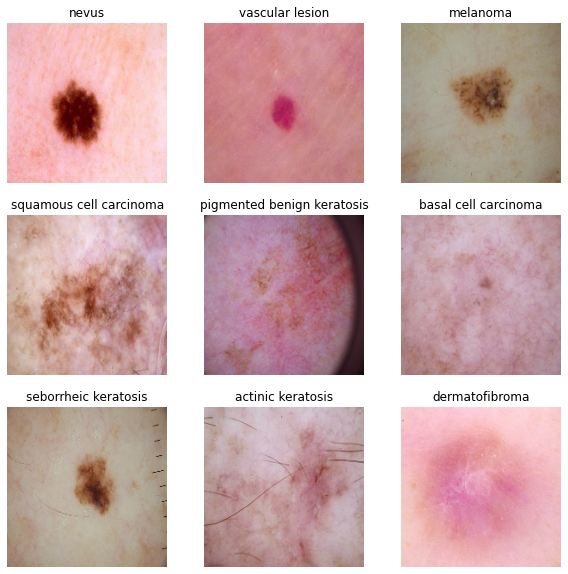

In [9]:
plt.figure(figsize=(10, 10))

flag_plot = 0
while flag_plot != 1:
    for images, labels in train_ds.take(1):
        if len(set(labels.numpy())) != 9:
            break

        else:
            flag_plot = 1

            labels_plotted = []
            counter = 0
            i=0
            while counter != len(labels):

                if class_names[labels[counter]] in labels_plotted:
                    counter+=1
                    continue
                else:
                    ax = plt.subplot(3, 3, i + 1)
                    plt.imshow(images[counter].numpy().astype("uint8"))
                    plt.title(class_names[labels[counter]])
                    plt.axis("off")
                    labels_plotted.append(class_names[labels[counter]])
                    i+=1
                    counter+=1
      

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

---

### MODELLING - Iteration 1

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Defning The Model Class

- Since we will use the <b>"Conv2D + Batch Normalisation + MaxPooling"</b> layer a lot of times, the code can be kept clean by creating a class which inherits from keras.layers.Layer parent class
- It is constructed using Keras Functional API, and can be reused as a layer in the Sequential API {Model Subclassing}

In [4]:
class CNNBlock(keras.layers.Layer):
    """
    Class for defining the combination of
    Conv2d + Batch Norm + ReLU
    
    :attributes:
    
    > out_channels: Total Number of Filters to create feature maps
    > kernel_size: Size of the kernel used for convolution
    > add_batch_norm: [bool, Default = False] Whether or not to use batch normalisation for the block
    
    :methods:
    
    > call(): In this function, the network is created using the keras
    Functional API.
    This is a standard method overriding step for any class inherrited
    from keras.layers.Layer parent class.
    """
    def __init__(self, out_channels, kernel_size = 3, add_batch_norm = False):
        super(CNNBlock, self).__init__()
        self.add_batch_norm = add_batch_norm
        self.conv = keras.layers.Conv2D(out_channels, kernel_size, padding = "same")
        self.batch_norm = keras.layers.BatchNormalization()
        self.maxpool = keras.layers.MaxPool2D(pool_size=(2, 2))
        
    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        if self.add_batch_norm:
            x = self.batch_norm(x, training = training)
        x = keras.layers.ReLU()(x)
        x = self.maxpool(x)
        return x

### Creating The Model Architecture

In [12]:
model = keras.Sequential([
    keras.layers.Rescaling(1./255., input_shape = (img_height, img_width, 3)),
    CNNBlock(32),
    CNNBlock(64),
    CNNBlock(128),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dense(9, activation = 'softmax')
])
        

### Compiling the model


#### Choosing the proper optimizer, loss function and an optimal learning rate

In [13]:
lr = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss_function = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer = optimizer,
              loss= loss_function,
              metrics=['accuracy'],)

##### Visualising The Model Architecture with the Number of Trainable Parameters

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 cnn_block (CNNBlock)        (None, 90, 90, 32)        896       
                                                                 
 cnn_block_1 (CNNBlock)      (None, 45, 45, 64)        18496     
                                                                 
 cnn_block_2 (CNNBlock)      (None, 22, 22, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 61952)             0         
                                                                 
 dense (Dense)               (None, 512)               31719936  
                                                                 
 dense_1 (Dense)             (None, 256)               1

### Model Training

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose = True
)

Epoch 1/20
56/56 [==============================] - 290s 1s/step - loss: 2.2558 - accuracy: 0.2227 - val_loss: 1.8742 - val_accuracy: 0.3468
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.7405 - accuracy: 0.3856 - val_loss: 1.5294 - val_accuracy: 0.4922
Epoch 3/20
56/56 [==============================] - 3s 45ms/step - loss: 1.5470 - accuracy: 0.4531 - val_loss: 1.4408 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 3s 46ms/step - loss: 1.3949 - accuracy: 0.5246 - val_loss: 1.4095 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 3s 45ms/step - loss: 1.3153 - accuracy: 0.5368 - val_loss: 1.5349 - val_accuracy: 0.4832
Epoch 6/20
56/56 [==============================] - 3s 46ms/step - loss: 1.2500 - accuracy: 0.5485 - val_loss: 1.4376 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.2005 - accuracy: 0.5798 - val_loss: 1.4921 - val_accuracy: 0.5056
Epoch 8/20
56

### Visualizing training results

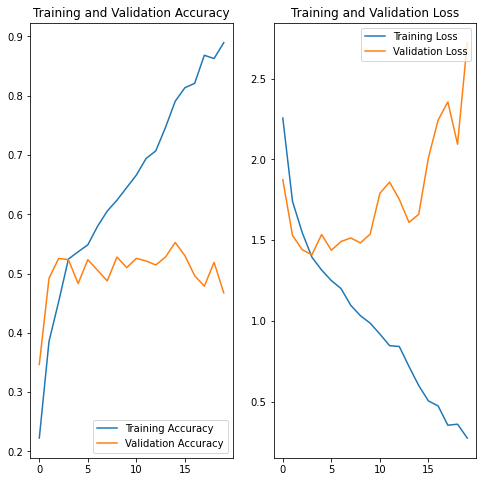

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference

- The Model Overfits on the Data, which is evident from the training/validation curve
    - The training Accuracy keeps increasing while the Validation Accuracy is clamped at around 50% 
    - The training loss keeps decreasing but the validation loss increases

---

### MODELLING - Iteration 2

To deal with the model overfitting, we create augmentation layers which randomly flips/rotates/zooms the images during training
[Note: it does not physically increase the size of the dataset]

In [17]:
data_augmentation_layer = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

#### Visualising an Example of How Augmentation Layer Works on a sample image

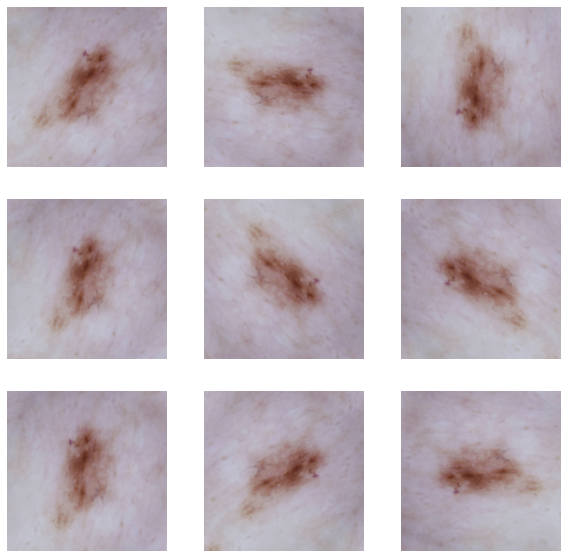

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation_layer(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Create Model With the Augmentation Layers

#### Since the difference between training and validation accuracy is quite a lot, a single layer of dropout is used at the end of the convolution blocks

In [19]:
model2 = keras.Sequential([
    data_augmentation_layer,
    keras.layers.Rescaling(1./255.),
    CNNBlock(32),
    CNNBlock(64),
    CNNBlock(128),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation = 'relu'),
    # keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation = 'relu'),
    # keras.layers.Dense(0.3),
    keras.layers.Dense(9, activation = 'softmax')
])


### Compiling the model

In [20]:
model2.compile(optimizer = optimizer,
              loss= loss_function,
              metrics=['accuracy'],)

### Training the model

In [21]:
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)


Epoch 1/20
56/56 [==============================] - 5s 74ms/step - loss: 2.6060 - accuracy: 0.1992 - val_loss: 2.0271 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 4s 76ms/step - loss: 2.0213 - accuracy: 0.1942 - val_loss: 2.0208 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 4s 71ms/step - loss: 2.0201 - accuracy: 0.1881 - val_loss: 2.0252 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 4s 70ms/step - loss: 2.0182 - accuracy: 0.1869 - val_loss: 2.0257 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 4s 70ms/step - loss: 2.0182 - accuracy: 0.2003 - val_loss: 2.0270 - val_accuracy: 0.1924
Epoch 6/20
56/56 [==============================] - 4s 70ms/step - loss: 2.0168 - accuracy: 0.1864 - val_loss: 2.0220 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 2.0170 - accuracy: 0.2065 - val_loss: 2.0260 - val_accuracy: 0.1924
Epoch 8/20
56

### Visualizing the results

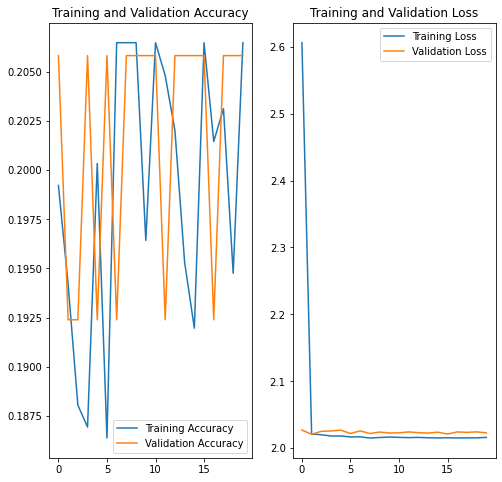

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference

- The model underfits on the data as the accuracy drops to 20% levels.
- This signifies that there may be some other reason behind the model overfitting

---

### MODELLING - Iteration -3

#### Visualising the Samples Count in Each Class

In [23]:
samples_count = []
for i in class_names:
    class_path = data_dir_train / i
    samples = len(list(class_path.glob("*.jpg")))
    samples_count.append(samples)

df_samples_count = pd.DataFrame({'class_names': class_names,
                                 'samples_count': samples_count},)
df_samples_count

,class_names,samples_count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


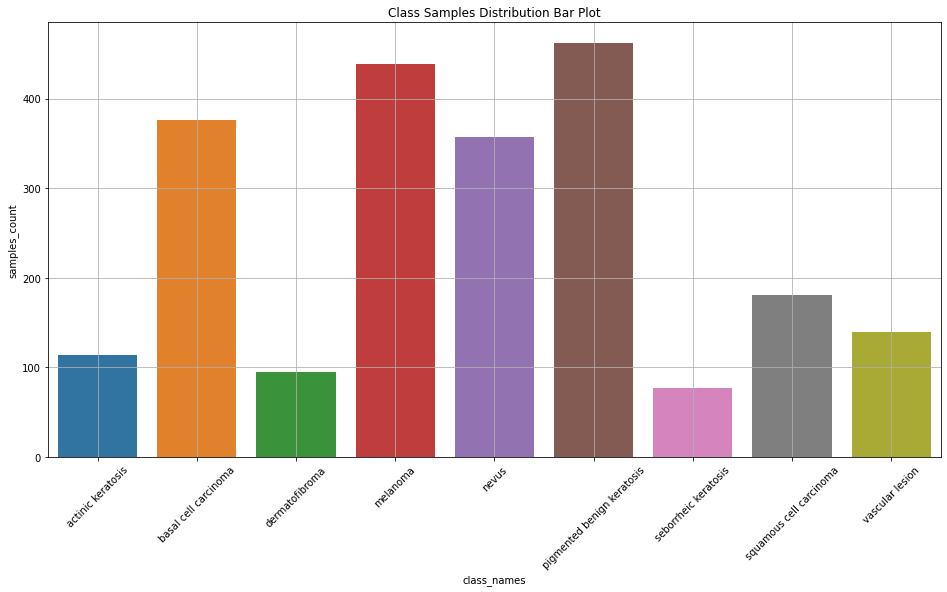

In [24]:
import seaborn as sns
plt.figure(figsize = (16, 8))
sns.barplot(data = df_samples_count, x = 'class_names', y = 'samples_count')
plt.grid()
plt.xticks(rotation = 45)
plt.title("Class Samples Distribution Bar Plot")
plt.show()

### Inference

- The barplot shows the presence of class imbalance in the data
- <b>Seborrheic Keratosis</b> has the least number of samples (77)
- <b>Pigmented Benign Keratosis</b> has the most number of samples (462)

---

#### To Rectifying Class Imbalance, We use an External Package known as Augmentor

In [25]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- Creating synthetic samples using Augmentor
- 500 synthetic samples are added to each class to reduce the percentage of class imbalance

In [26]:
path_to_training_dataset= data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning Projects/CS-Melanoma/original data/data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F17B6179350>: 100%|██████████| 500/500 [00:23<00:00, 20.89 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning Projects/CS-Melanoma/original data/data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F17B88A3FD0>: 100%|██████████| 500/500 [00:19<00:00, 25.20 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning Projects/CS-Melanoma/original data/data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F17B6158710>: 100%|██████████| 500/500 [00:18<00:00, 26.70 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning Projects/CS-Melanoma/original data/data/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F17B6158910>: 100%|██████████| 500/500 [01:27<00:00,  5.68 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning Projects/CS-Melanoma/original data/data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F17B896A2D0>: 100%|██████████| 500/500 [01:26<00:00,  5.78 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning Projects/CS-Melanoma/original data/data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F17B887DCD0>: 100%|██████████| 500/500 [00:17<00:00, 27.83 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning Projects/CS-Melanoma/original data/data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F17B8BD44D0>: 100%|██████████| 500/500 [00:40<00:00, 12.27 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning Projects/CS-Melanoma/original data/data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F182036CDD0>: 100%|██████████| 500/500 [00:18<00:00, 27.65 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep Learning Projects/CS-Melanoma/original data/data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F17B8DD05D0>: 100%|██████████| 500/500 [00:21<00:00, 23.09 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Visualising the New Distribution of Samples in Each Class

In [28]:
from glob import glob

In [29]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
df_samples_count_new = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df_samples_count_new = df_samples_count_new.groupby("Label", as_index = False)['Path'].count()
df_samples_count_new.rename(columns = {'Path': 'samples_count', 'Label': 'class_names'}, inplace = True)
df_samples_count_new = df_samples_count_new[['class_names', 'samples_count']]

df_total_samples = pd.concat([df_samples_count, df_samples_count_new], axis = 'rows', ignore_index =True)
df_total_samples = df_total_samples.groupby("class_names", as_index = False)['samples_count'].sum()

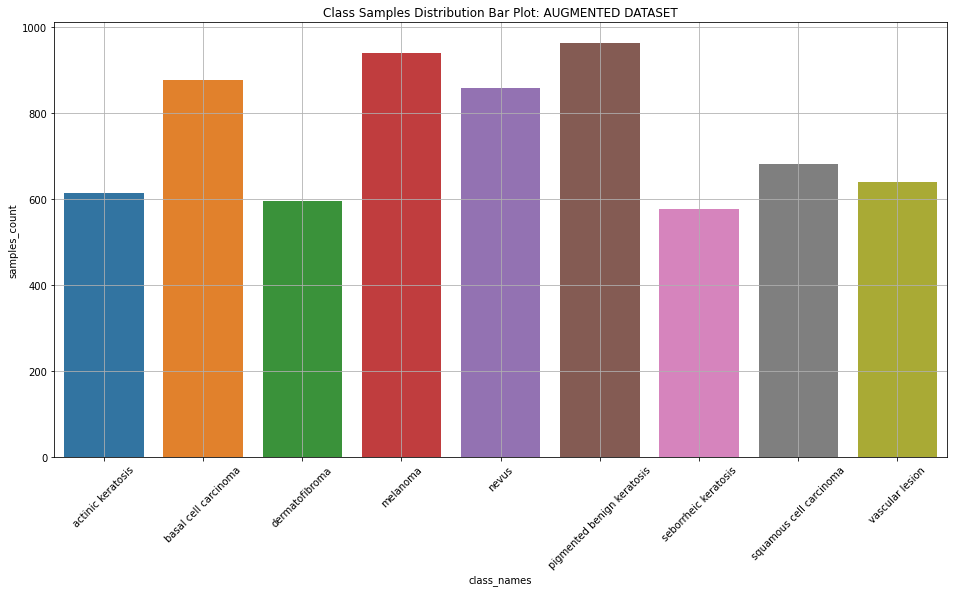

In [33]:
plt.figure(figsize = (16, 8))
sns.barplot(data = df_total_samples, x = 'class_names', y = 'samples_count')
plt.grid()
plt.xticks(rotation = 45)
plt.title("Class Samples Distribution Bar Plot: AUGMENTED DATASET")
plt.show()

#### Inference

- The Percentage of Class Imbalance has reduced due to adding augmented images to the dataset

---

### Defining The New Training and Validation Dataset

In [35]:
data_dir_train=data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  shuffle = True,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  # shuffle = True, 
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the Final Model Architecture

- We remove the augmentation layer as physical augmentation has been done already through Augmentor
- We use `dropout()` layer towards the end of last two Conv layers [as the last layers pick more fine grained features and have a higher chance to overfit], and the fully connected layers

In [38]:
model3 = keras.Sequential([
    keras.layers.Rescaling(1./255.),
    CNNBlock(32),
    CNNBlock(64),
    CNNBlock(128),
    keras.layers.Dropout(0.2),
    CNNBlock(128),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(9, activation = 'softmax')
])

### Compiling The Model

In [39]:
lr = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss_function = keras.losses.SparseCategoricalCrossentropy()
model3.compile(optimizer = optimizer,
              loss= loss_function,
              metrics=['accuracy'],)

### Training the Model For 30 Epochs

In [40]:
epochs = 30
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/30
169/169 [==============================] - 37s 79ms/step - loss: 2.0379 - accuracy: 0.1999 - val_loss: 1.7231 - val_accuracy: 0.2821
Epoch 2/30
169/169 [==============================] - 7s 43ms/step - loss: 1.7462 - accuracy: 0.3214 - val_loss: 1.5365 - val_accuracy: 0.4076
Epoch 3/30
169/169 [==============================] - 7s 43ms/step - loss: 1.5770 - accuracy: 0.3943 - val_loss: 1.5094 - val_accuracy: 0.4172
Epoch 4/30
169/169 [==============================] - 7s 43ms/step - loss: 1.4715 - accuracy: 0.4217 - val_loss: 1.4030 - val_accuracy: 0.4373
Epoch 5/30
169/169 [==============================] - 7s 43ms/step - loss: 1.4101 - accuracy: 0.4484 - val_loss: 1.2779 - val_accuracy: 0.4751
Epoch 6/30
169/169 [==============================] - 7s 43ms/step - loss: 1.3411 - accuracy: 0.4696 - val_loss: 1.2363 - val_accuracy: 0.4744
Epoch 7/30
169/169 [==============================] - 7s 43ms/step - loss: 1.2904 - accuracy: 0.4981 - val_loss: 1.2487 - val_accuracy: 0.484

#### Visualising the Results

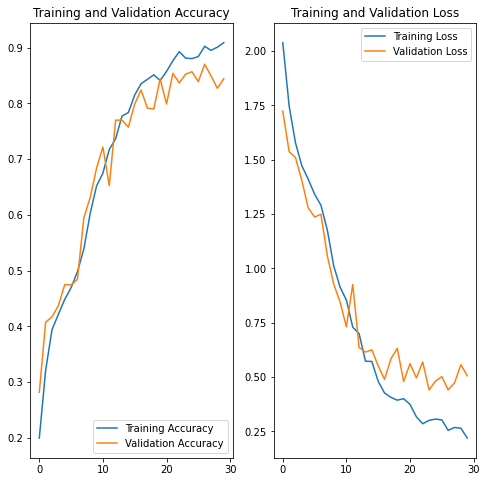

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference

- The Performance of the Model has improved greatly by using Augmentor layer.
- The Model is now reporting an accuracy of over 80% for both training and validation sets
- The performance of the model drops while using Batch Normalisation [internally verified], so Batch Normalisation has been excluded from the network [possible explanation can be because the batch size is small, or the network is not too deep to actually benefit from batch normalisation]